In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy
from IPython import display
import seaborn as sns
from scipy import signal
import parkinson_modules as pm
import warnings
import pickle
from scipy.signal import butter, welch, filtfilt
import time
warnings.filterwarnings('ignore')
%matplotlib inline
os.chdir('C:\Files\parkinson')
info = pd.read_excel('Info.xlsx')
info = info.fillna(value = -1)
info.head(5)

,date,ID,ФИО,пол,возраст,Степень Паркинсона,Травмы/Патологии/Болезни,Баг в эксперименте1,Баг в эксперименте2,index1,index2,Unnamed: 11,postural,kinetic,rest
0,-1,1,Екатерина К,ж,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
1,-1,2,Анна Т,ж,23.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
2,-1,3,Александр Т,м,22.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
3,-1,4,Иван Д,м,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
4,-1,5,Дмитрий Е,м,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0


In [2]:
features = pd.read_pickle('C:/Files/parkinson/features_1000points_50overlap_new_2std.pkl')
file = pd.read_pickle('C:/Files/parkinson/data_5s.pkl')

In [3]:
# with open('C:/Users/alexandr/Desktop/python/Parkinson-s_Disease-master/Fingers-Detection-using-OpenCV-and-Python-master/movement_dictionary.pkl', 'rb') as f:
#     movements_dct = pickle.load(f)

In [4]:
# os.chdir('C:/Files/parkinson/PatientDataV2/')
# path = 'C:/Files/parkinson/PatientDataV2/'
# feature = {}
# file = pd.DataFrame()
# list_files = os.listdir()
# count = 0
# for name in list_files:
#     if '.' in name:
#         continue
# #         patient = pm.parkinson(path + name)
#     index = [int(name[7:])]
#     print(name)
#     patient_info = info[info['ID'] == index[0]]
#     folders = os.listdir(path + name)
# #         if True: #(patient_info['Баг в эксперименте' + str(index[1])][index[0] - 1] == -1):
#     for fold in folders:
#         if '.' in fold:
#             continue
#         index = list(map(int, fold.split('_')))
#         if len(index) == 1:
#             index.append(1)
#         patient = pm.parkinson(path + name + '/' + fold)
#         patient.read()
#         for exer_keys in patient.exercises:
#             exers = patient.exercises[exer_keys]
#             timing = patient.time[exer_keys]
#             df = pm.calculate_batch({key : exers[key] for key in pm.columns_acc},
#                                     {key : exers[key] for key in pm.columns_hyr},
#                                     {key : exers[key] for key in pm.columns_mag},
#                                      timing, patient_info, index[0], file, exer_keys, index, win_size = 1000, overlap= 50)
#             movement_list_df= []
#             if exer_keys in movements_dct[fold]:
#                 time = movements_dct[fold][exer_keys]['time']
#                 movement = movements_dct[fold][exer_keys]['movements']
#             else:
#                 time = np.arange(1000)
#                 movement = np.zeros(1000)
#             for df_index in df.index:
#                 timing = df['time'][df_index]
#                 indexes = np.argwhere((time > timing[0])*(time < timing[-1]))
#                 movement_list_df.append(np.array(movement)[indexes.astype(np.int)][:,0])
#             df['movements'] = movement_list_df
#             file = file.append(df, ignore_index=True)


In [5]:
file.shape

(9194, 14)

In [6]:
# file.to_pickle('C:/Files/parkinson/data_5s.pkl')

In [7]:
# features = pm.feature_extract(file)

In [8]:
moves = []
for move in file['movements']:
    moves.append(move.mean())
moves = np.array(moves)

In [9]:
features['movement'] = moves

In [10]:
features.shape, file.shape

((9194, 472), (9194, 14))

In [11]:
features.exercise_index.value_counts()

9.0     2907
10.0     958
11.0     714
2.0      701
8.0      671
13.0     562
14.0     543
15.0     505
6.0      375
5.0      305
12.0     260
7.0      234
4.0      195
1.0      160
3.0      104
Name: exercise_index, dtype: int64

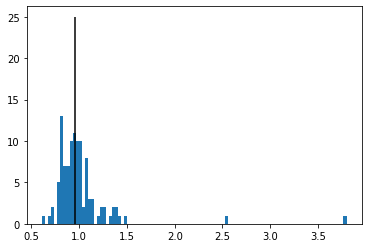

In [12]:
plt.hist(features[features.name == 50].movement, bins = 100)
plt.vlines(features[features.name == 50].movement.median(), ymin =0, ymax = 25)

In [13]:
brady = []
for index in features.index:

    exer_index = features['exercise_index'][index]
    name = features['name'][index]
    median = features[features.name == name].movement.median()
    movement = features['movement'][index]
    if movement<median:
        brady.append(-1)
    else:
        if features['target'][index] == 0:
            brady.append(0)
        else:
            brady.append(1)
#     if exer_index in [2,8,13,14,15]:
#         brady.append(-1)
#         continue

        #     print(ampl)

#         else:
#             brady.append(0)
    
#     break

In [14]:
moves1 = []
moves2 = []
for index in features.index:
    exer_index = features['exercise_index'][index]

    if exer_index in [2,8,13,14,15]:
        moves1.append(features['movement'][index])
    else:
        moves2.append(features['movement'][index])

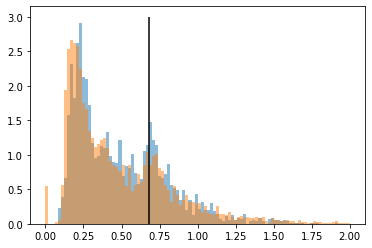

In [15]:
plt.hist(moves1, density=True, bins = 100, alpha = 0.5, range=(0,2))
plt.hist(moves2, density=True, bins = 100, alpha = 0.5, range=(0,2))
plt.vlines(0.68, ymin = 0, ymax =3)
plt.show()

In [16]:
features['brady_indentity'] = brady

In [17]:
datka = features
datka = datka[datka.target != 4]
datka = datka[datka.target != 1]
datka.shape

(5820, 473)

In [18]:
datka = datka[datka.brady_indentity != -1]
datka.shape

(3106, 473)

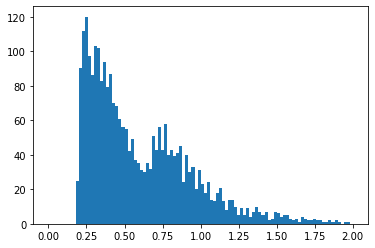

In [19]:
plt.hist(datka.movement, bins = 100, range = (0,2))
plt.show()

In [20]:
corr = datka.corr()

In [21]:
corr.brady_indentity.abs().sort_values()

gyr_y, dps_differential_mean                     0.000903
gyr_z, dps_trend_more3hz_dominant_frequency      0.001304
gyr_z, dps_trend_more3hz_peaks_freq_min          0.001304
mag_y, mga_trend_less3hz_peaks_amplitude_std     0.001686
acc_y, mg_differential_mean                      0.001714
acc_z, mg_trend_more3hz_peaks_freq_max           0.002027
acc_x, mg_trend_spectrum_energy_std              0.002617
mag_x, mga_noise_mean                            0.003200
gyr_x, dps_noise_mean                            0.003743
mag_y, mga_trend_more3hz_peaks_freq_mean         0.003841
gyr_y, dps_skew                                  0.005096
acc_y, mg_trend_more3hz_peaks_amplitude_mean     0.005162
gyr_x, dps_trend_more3hz_peaks_amplitude_mean    0.005823
mag_x, mga_trend_more3hz_dominant_frequency      0.005865
mag_x, mga_trend_more3hz_peaks_freq_min          0.005865
mag_z, mga_noise_more3hz_peaks_amplitude_min     0.005952
acc_y, mg_trend_more3hz_peaks_freq_max           0.006597
gyr_y, dps_tre

In [22]:
from sklearn.feature_selection import chi2
from tqdm import tqdm

def shuffler(df):
    # return the pandas dataframe
    return df.reindex(np.random.permutation(df.index))
# import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def CI_calculated(parkinson_df):
    df = parkinson_df.drop(index = ['exer_idx'])
    l_min = []
    l_max = []
    for col in df:
        x = df[col].values
        x = x[~np.isnan(x)]
        med, minim, maxim = mean_confidence_interval(x)
        l_min.append(minim)
        l_max.append(maxim)
    return l_min, l_max

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from fylearn.nfpc import FuzzyPatternClassifier
from fylearn.garules import MultimodalEvolutionaryClassifier
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC
import time 
FPC = FuzzyPatternClassifier()
MEC = MultimodalEvolutionaryClassifier(n_iterations= 20)
FPC = FuzzyPatternTreeTopDownClassifier()
parameters = {'n_estimators': np.arange(200, 501, 100), 'max_depth' : np.arange(10, 61, 10)}
RFС0 = RandomForestClassifier(n_estimators = 30, max_depth = 5, class_weight = 'balanced')
RFС1 = RandomForestClassifier(n_estimators = 130, max_depth = 35, class_weight = 'balanced')
RFС2 = RandomForestClassifier(n_estimators = 70, max_depth = 5, class_weight = 'balanced')
RFС3 = RandomForestClassifier(n_estimators = 130, max_depth = 5, class_weight = 'balanced')
RFС4 = RandomForestClassifier(n_estimators = 30, max_depth = 15, class_weight = 'balanced')
RFС5 = RandomForestClassifier(n_estimators = 50, max_depth = 15, class_weight = 'balanced')
RFС6 = RandomForestClassifier(n_estimators = 70, max_depth = 15, class_weight = 'balanced')
RFС7 = RandomForestClassifier(n_estimators = 90, max_depth = 15, class_weight = 'balanced')
RFС8 = RandomForestClassifier(n_estimators = 30, max_depth = 25, class_weight = 'balanced')
RFС9 = RandomForestClassifier(n_estimators = 50, max_depth = 25, class_weight = 'balanced')
RFС10= RandomForestClassifier(n_estimators = 70, max_depth = 25, class_weight = 'balanced')
RFС11= RandomForestClassifier(n_estimators = 90, max_depth = 25, class_weight = 'balanced')
RFС12= RandomForestClassifier(n_estimators = 110, max_depth = 35, class_weight = 'balanced')

# LinSVM = LinearSVC( probability= True, class_weight = 'balanced')
RbfSVM = SVC(kernel = 'rbf', probability= True, class_weight = 'balanced')
PolySVM = SVC(kernel = 'poly', class_weight = 'balanced')
KNN = KNeighborsClassifier()
NB = GaussianNB()
LR = LogisticRegression(class_weight= 'balanced')
DT = DecisionTreeClassifier(max_depth = 100, class_weight='balanced')
QDA = QuadraticDiscriminantAnalysis()
GP = GaussianProcessClassifier(1.0 * RBF(1.0))
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
classifiers = {
#      'RF 30 5' : RFС0,
#      'RF 130 35' : RFС1,
#      'RF 70 5' : RFС2,
#      'RF 130 5' : RFС3,
#      'RF 30 15' : RFС4,
#      'RF 50 15' : RFС5,
#      'RF 90 15' : RFС7,
#      'RF 30 25' : RFС8,
#      'RF 50 25' : RFС9,
#      'RF 70 25' : RFС10,
#      'RF 90 25' : RFС11,
     'RF 110 35' : RFС12
    
#      'Linear SVM' : LinSVM,
#      'rbf SVM' : RbfSVM,
#      'poly SVM': PolySVM,
#      'KNN' : KNN, 
#      'NB' : NB,
#      'LR' : LR,
#     'Adaboost' : AdaBoostClassifier(n_estimators = 50),
#     'SGD' : SGDClassifier(n_jobs= 4, class_weight= 'balanced' )
#      'DT' : DT,
#      'GaussProcess' : GP,
#      'QDA' : QDA
#      'Fuzzy Pattern' : FPC,
#      'MultiModalEvolutionary' : MEC,
#      'FuzzyPatternTreeTopDown' : FPC
}

In [1]:
def small_predict(train_df, test_df, classifiers, accuracy, i=0, initial_feat_x = None):
    
    X_train = train_df.drop(columns = ['name', 'exercise_index', 'target', 'brady_indentity'])
    y_train = train_df.brady_indentity.values
    X_test = test_df.drop(columns = ['name', 'exercise_index', 'target', 'brady_indentity'])
    y_test = test_df.brady_indentity.values
    
    if initial_feat_x:
        X_train = X_train[initial_feat_x]
        X_test  = X_test[initial_feat_x]
    feature_names = X_train.columns.copy()
    a, b = chi2(X_train.abs(),y_train)
    ind = np.argsort(a)
    selected_names = list(feature_names[ind])
#     print(len(selected_names))
#     for n_feat in range(50, len(selected_names), 100):
    n_feat = len(selected_names)
    X_train = pm.sclr.fit_transform(train_df[selected_names[:n_feat] ])
    X_test  = pm.sclr.transform(    test_df[ selected_names[:n_feat] ])
    for key in classifiers:
#         print(key)
        model = classifiers[key]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if key + ', n_feat= ' + str(n_feat) not in accuracy:
            accuracy[key + ', n_feat= ' + str(n_feat)] = []
        accuracy[key + ', n_feat= ' + str(n_feat)].append(pm.accuracy_score(y_pred, y_test))
#         print(n_feat, len(selected_names))

    if 'person' not in accuracy:
        accuracy['person'] = []
    accuracy['person'].append(i)
    return accuracy

In [30]:
accuracy = {}
accuracy_acc = {}
accuracy_gyr = {}
accuracy_mag = {}
accuracy_without_acc = {}
accuracy_without_gyr = {}
accuracy_without_mag = {}
# results_per_person_pon = {}
df = datka.drop(columns=['movement'])
peoples = df.name.unique()
st = 0
for i in peoples:
#     if i in accuracy['person']:
#         continue
    train_df = shuffler(df[df['name'] != i])
    test_df  = df[df['name'] == i]
    
    print(i, ', len test', len(test_df), ', time:', time.time() - st)
    
    st = time.time()
### Total Accuracy
#     X_train, y_train, X_test, y_test = use_this_features(train_df, test_df)
    accuracy = small_predict(train_df, test_df, classifiers,
                             accuracy, i)
    accuracy_acc = small_predict(train_df, test_df, classifiers, 
                                 accuracy_acc, i, initial_feat_x = acc_feat)
    accuracy_gyr = small_predict(train_df, test_df, classifiers, 
                                 accuracy_gyr, i, initial_feat_x = gyr_feat)
    accuracy_mag = small_predict(train_df, test_df, classifiers,
                                 accuracy_mag, i, initial_feat_x = mag_feat)
    accuracy_without_acc = small_predict(train_df, test_df, classifiers,
                                         accuracy_without_acc, i, initial_feat_x = gyr_feat + mag_feat)
    accuracy_without_gyr = small_predict(train_df, test_df, classifiers,
                                         accuracy_without_gyr, i, initial_feat_x = acc_feat + mag_feat)
    accuracy_without_mag = small_predict(train_df, test_df, classifiers, 
                                         accuracy_without_mag, i, initial_feat_x = gyr_feat + acc_feat)

1.0 , len test 59 , time: 1572259604.9543374
2.0 , len test 62 , time: 17.13020396232605
3.0 , len test 58 , time: 17.884565353393555
4.0 , len test 60 , time: 17.534634113311768
5.0 , len test 60 , time: 16.464781999588013
6.0 , len test 70 , time: 16.872873544692993
7.0 , len test 59 , time: 16.13190269470215
8.0 , len test 59 , time: 17.851476192474365
9.0 , len test 65 , time: 16.703442335128784
10.0 , len test 64 , time: 16.14393448829651
11.0 , len test 53 , time: 16.987178325653076
12.0 , len test 55 , time: 16.49972367286682
13.0 , len test 46 , time: 17.65703296661377
14.0 , len test 97 , time: 16.718462705612183
15.0 , len test 116 , time: 15.87622356414795
16.0 , len test 120 , time: 15.934349775314331
17.0 , len test 51 , time: 15.967468738555908
18.0 , len test 51 , time: 15.996533155441284
19.0 , len test 48 , time: 15.97946834564209
21.0 , len test 55 , time: 16.04166293144226
23.0 , len test 98 , time: 16.41666269302368
24.0 , len test 78 , time: 16.433704137802124
26.0

In [31]:
pd.DataFrame(accuracy).drop(columns = ['person']).mean()

RF 110 35, n_feat= 468    0.796602
dtype: float64

In [32]:
pd.DataFrame(accuracy)

,"RF 110 35, n_feat= 468",person
0,0.966102,1.0
1,0.887097,2.0
2,0.982759,3.0
3,0.916667,4.0
4,0.916667,5.0
5,0.857143,6.0
6,0.898305,7.0
7,0.796610,8.0
8,0.738462,9.0
9,0.781250,10.0


In [33]:
acc_per_sensor = {}
acc_per_sensor['all'] = pd.DataFrame(accuracy)

acc_per_sensor['acc'] = pd.DataFrame(accuracy_acc)
acc_per_sensor['gyr'] = pd.DataFrame(accuracy_gyr)
acc_per_sensor['mag'] = pd.DataFrame(accuracy_mag)

acc_per_sensor['without_acc'] = pd.DataFrame(accuracy_without_acc)
acc_per_sensor['without_gyr'] = pd.DataFrame(accuracy_without_gyr)
acc_per_sensor['without_mag'] = pd.DataFrame(accuracy_without_mag)

In [34]:
acc_per_sensor['all'].mean()

RF 110 35, n_feat= 468     0.796602
person                    32.571429
dtype: float64

In [35]:
acc_per_sensor['acc'].mean(),acc_per_sensor['gyr'].mean(),acc_per_sensor['mag'].mean()

(RF 110 35, n_feat= 156     0.742657
 person                    32.571429
 dtype: float64, RF 110 35, n_feat= 156     0.746150
 person                    32.571429
 dtype: float64, RF 110 35, n_feat= 156     0.740000
 person                    32.571429
 dtype: float64)

In [36]:
acc_per_sensor['without_acc'].mean(), acc_per_sensor['without_gyr'].mean(), acc_per_sensor['without_mag'].mean()

(RF 110 35, n_feat= 312     0.778477
 person                    32.571429
 dtype: float64, RF 110 35, n_feat= 312     0.789186
 person                    32.571429
 dtype: float64, RF 110 35, n_feat= 312     0.757614
 person                    32.571429
 dtype: float64)

In [ ]:
with open('C:/Files/parkinson/brady_acc_per_sensor.pkl', 'wb') as config_dictionary_file:
    pickle.dump(acc_per_sensor, config_dictionary_file)

In [ ]:
with open('C:/Files/parkinson/brady_acc_per_sensor.pkl', 'rb') as config_dictionary_file:
    acc_per_sensor = pickle.load(config_dictionary_file)
 

In [ ]:
best_model_name = {key : acc_per_sensor[key].mean().sort_values().keys()[-2] for key in acc_per_sensor}
best_model_accuracy = {key : acc_per_sensor[key].mean().sort_values().values[-2] for key in acc_per_sensor}
best_model_accuracy